In [1]:
# pip install rich ipywidgets

In [2]:
import torch 
from biotite.sequence.io.fasta import FastaFile
from rich.progress import track 
import torch.nn.functional as F
import plotly.express as px 
import matplotlib.pyplot as plt 

torch.manual_seed(13)

In [3]:
# read in our FASTA file 
input_file = "./fasta/hypf.fa"

proteins = []
fasta_file = FastaFile.read(input_file) 
for header, sequence in fasta_file.items():
    proteins.append(sequence)

max_protein_length = max(len(w) for w in proteins)

proteins[:3], max_protein_length

(['MCLLSLAAATVAARRTPLRLLGRGLAAAMSTAGPLKSVDYEVFGRVQGVCFRMYTEGEAKKIGVVGWVKNTSKGTVTGQVQGPEDKVNSMKSWLSKVGSPSSRIDRTNFSNEKTISKLEYSNFSIRY',
  'MSSQIKKSKTTTKKLVKSAPKSVPNAAADDQIFCCQFEVFGHVQDFSGVFFRKHTQKKANELGITGWCMNTTRGTVQGMLEGSLDQMTDMKYWLQHKGSPRSVIEKAVFSENEALPINNFKMFSIRR',
  'MLTKLYLKIVLCLLVALPFLSEVTSQNTDTTMTKLVGVDFEVYGRVQGVFFRKYTQKHSTELGLKGWCMNTDKGTVVGRIEGEKEKVEQMKNWLRYTGSPQSAIDKAEFKNEKELSQPSFTNFEIKK'],
 127)

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(proteins))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'A', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'P', 14: 'Q', 15: 'R', 16: 'S', 17: 'T', 18: 'V', 19: 'W', 20: 'X', 21: 'Y', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for protein in proteins:
  
  #print(w)
  context = [0] * block_size
  for ch in protein + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([2592974, 3]), torch.int64, torch.Size([2592974]), torch.int64)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(proteins):  
  X, Y = [], []
  for w in proteins:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(proteins)
n1 = int(0.8*len(proteins))
n2 = int(0.9*len(proteins))

Xtr, Ytr = build_dataset(proteins[:n1])
Xdev, Ydev = build_dataset(proteins[n1:n2])
Xte, Yte = build_dataset(proteins[n2:])


torch.Size([2075077, 3]) torch.Size([2075077])
torch.Size([259018, 3]) torch.Size([259018])
torch.Size([258879, 3]) torch.Size([258879])


In [8]:
vocab_size = len(chars) + 1

C = torch.randn((vocab_size, 2))

In [9]:
emb = C[X]
emb.shape

torch.Size([2592974, 3, 2])

In [10]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [11]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [12]:
h

tensor([[-0.9771,  0.2311, -0.1473,  ..., -0.8784,  0.9636, -0.5723],
        [-0.9486,  0.7366, -0.1345,  ..., -0.1930,  0.8090, -0.9160],
        [ 0.9051,  0.9992, -0.4432,  ...,  0.7134,  0.3724, -0.6566],
        ...,
        [-0.8140, -1.0000,  0.9405,  ..., -1.0000,  0.9816,  0.5699],
        [-0.9105, -1.0000,  0.9844,  ..., -1.0000,  0.9896, -0.4413],
        [-0.9999, -1.0000,  0.9892,  ..., -1.0000,  0.9903, -0.9990]])

In [13]:
h.shape

torch.Size([2592974, 100])

In [14]:
W2 = torch.randn((100, vocab_size))
b2 = torch.randn(vocab_size)

In [15]:
logits = h @ W2 + b2

In [16]:
logits.shape

torch.Size([2592974, 22])

In [17]:
counts = logits.exp()

In [18]:
prob = counts / counts.sum(1, keepdims=True)

In [19]:
prob.shape

torch.Size([2592974, 22])

In [20]:
loss = -prob[torch.arange(X.shape[0]), Y].log().mean()
loss

tensor(17.8426)

In [21]:
# ------------ now made respectable :) ---------------

In [22]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([2075077, 3]), torch.Size([2075077]))

In [23]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

In [24]:
sum(p.nelement() for p in parameters) # number of parameters in total

10842

In [25]:
for p in parameters:
  p.requires_grad = True

In [26]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [27]:
lri = []
lossi = []
stepi = []

In [28]:
for i in track(range(200000)):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  #print(emb.shape)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, vocab_size)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

Output()

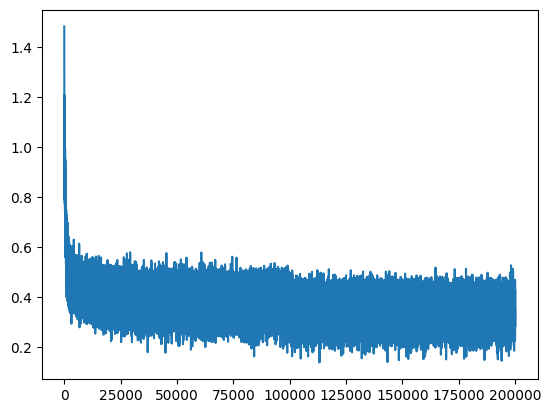

In [44]:
plt.plot(stepi, lossi) 

In [30]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, vocab_size)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2453, grad_fn=<NllLossBackward0>)

In [31]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, vocab_size)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2495, grad_fn=<NllLossBackward0>)

In [32]:
itos

{1: 'A',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'K',
 10: 'L',
 11: 'M',
 12: 'N',
 13: 'P',
 14: 'Q',
 15: 'R',
 16: 'S',
 17: 'T',
 18: 'V',
 19: 'W',
 20: 'X',
 21: 'Y',
 0: '.'}

In [33]:
C.shape

torch.Size([22, 10])

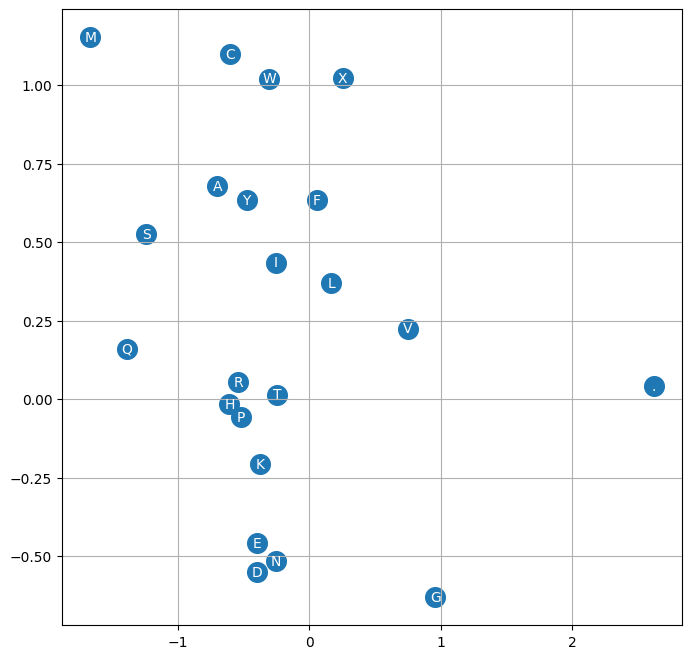

In [34]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    itos[i]
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [35]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [36]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [37]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(f">sample\n{''.join(itos[i] for i in out)}")

>sample
MKAKKLGLLISGVWYRRARVDGRVDGWVRNLPDASFYIRL.
>sample
MAEQLFVFSNFEATVERVEAMGAKILAQDGAVEVLLSDGRDEVVAHGDVQGPPGAAANTPGLKGWVRNRRFTRFRGFRWYVRNLPDGQVQKQHARAGPPGARTPGHPCQVGPRSAQVAGYEGPEEPPIQPSAERLGLAGWHRSIRY.
>sample
MGSASRLWKDFKSFGVVQRLGTLGLTGYTRGFIIC.
>sample
MAESSADIIEGRVEIIDWLESLESLENFDGSVEYAQKMVSGFAIVSGEVGVNGRVQGVGFACRVEFSRLLEQLKAGPIRAQVDRVEVSSEEHVIIW.
>sample
MSEARTEAEGPATVSLVKLTCWAASQACGEMVAWLKEGLTGWVRNLDDGSVEEVIAQEIIKGKVQGEVEMEVYGRVQIQGLLRLRAVGIYVRAASEAKAKKQIPATALITGWVRNLPDHVVKRAMARQLAAGVPGTVPRVAGFAKNMAEGEPTPDAVYIKNLPDGRVQGVGFRYSYNQKDGLLAWVRGEAVIESPIDGWVKGYVRNEPDGRVQGVIKPTEEVRTRCSRMIARDLGLNGFTERVTEHGLTEPHDGSVDFEVAANLEQGPRSRAVE.
>sample
MTKKHKQLNALNLSHDGSSIEMLLRGWCKRGPRSAWVYYRAFVSEQHIATPGRVEIVAIIVDAFKKKIENSLKKGPLLENFARAREIDLVEWCRERAEIAQEIGPSEARGLVGWVRNERSPVEVLAESQRLGVTGFAIRAIAVKRNEYDGSVFINTVTWVVGKVQGVKGAANMANLEGDRDEALMELVEEMTVQGVSGHVQGVGAQDIIRL.
>sample
MRKLGVKGYARVEGLHGHVQGVFFRKYGSFGCPVKILFIKITAQDLELARRESVDVEEELEDGPQLRLREYEGEEDLYGWVKNRFEILGARVFEGPPSSDGEVQGVGFRWSRATAGTAEAVLSEPAEARA